In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [170]:
train = pd.read_csv("./split/train.csv")

In [171]:
dev = pd.read_csv("./split/dev.csv")

In [172]:
test = pd.read_csv("./split/test.csv")

In [173]:
dataset = pd.read_csv("../data/train.csv")

In [174]:
companies = pd.Series(dataset["company1"].append(dataset["company2"]).value_counts().keys().values)
companies[:5]

0                   YouTube
1                    Google
2                Amazon.com
3    Verizon_Communications
4            Alexa_Internet
dtype: object

In [175]:
TEXT = "aliased_snippet"
RESULT = "is_parent"
COMPANY1= "company1"
COMPANY2 = "company2"

In [176]:
corpus = train[TEXT].append(dev[TEXT]).append(test[TEXT]).append(companies)
corpus.shape

(79834,)

In [177]:
train[:5]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet
0,51579,Pfizer,Medivation,True,What Will Pfizer Gain FromMedivationn Inc Win...,what will company1 gain from company2 n inc ...
1,40891,The_Walt_Disney_Company,NBCUniversal,False,One media executive said it may be difficult ...,one media executive said it may be difficult ...
2,30797,AT&T,DirecTV,True,\nFailure of Comcast?s merger could also press...,\nfailure of comcast?s merger could also press...
3,70215,DStv,MultiChoice,False,MultiChoicee Ghana adds more local channels on...,company2 e ghana adds more local channels on ...
4,39242,Google,AT&T,False,"While Google won that battle, AT&T filed a la...","while company1 won that battle, company2 ..."


In [178]:
# the idea here is to add whether company1 is before company2
def add_company_pos_ratio(company, row): 
    return row[TEXT].find(company) / len(row[TEXT])

In [179]:
from sklearn.base import TransformerMixin,  BaseEstimator

In [180]:
class RatioPos(TransformerMixin,BaseEstimator):
    def __init__(self, company):
        self.company = company
    def transform(self, X, **kwargs):
        return X.apply((lambda x: add_company_pos_ratio(self.company, x)), axis=1)
    def fit(self, X, y=None, **kwargs):
        return self

In [181]:
train["company1_pos"] = RatioPos(COMPANY1).fit_transform(train)
train["company2_pos"] = RatioPos(COMPANY2).fit_transform(train)

In [204]:
train[train["company1_pos"] < 0].shape

(49, 8)

In [205]:
train[train["company2_pos"] < 0].shape

(146, 8)

In [200]:
train[train["company1_pos"] < 0][:5]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet,company1_pos,company2_pos
1696,18473,GMC_(automobile),General_Motors,False,\nJob security arose as an issue earlier this ...,\njob security arose as an issue earlier this ...,-0.004878,0.273171
1969,77520,GMC_(automobile),General_Motors,False,The company offers the connections across its...,the company offers the connections across its...,-0.003521,0.320423
2546,61158,GMC_(automobile),General_Motors,False,"But its Buick, Chevrolet and General_MotorsC_...","but its buick, chevrolet and company2 c_(aut...",-0.004464,0.138393
2860,57009,GMC_(automobile),General_Motors,False,"General_MotorsM recalling about 700,000 Chevy ...","company2 m recalling about 700,000 chevy and ...",-0.004831,0.004831
3170,66822,GMC_(automobile),General_Motors,False,"General_MotorsC_(automobile), General_Motors'...","company2 c_(automobile), company2 's truck-...",-0.009709,0.019417


In [202]:
train.iloc[1696][TEXT]

"\njob security arose as an issue earlier this year when  company2  said it would shift production of the equinox's  company2 c twin, the terrain, to mexico, leading to the elimination of 600 jobs. ###end###"

In [203]:
train.iloc[1696]["snippet"]

"\nJob security arose as an issue earlier this year when General_Motors said it would shift production of the Equinox's General_MotorsC twin, the Terrain, to Mexico, leading to the elimination of 600 jobs. ###END###"

In [210]:
train[train["company1_pos"]][train[RESULT]==True].shape

KeyError: '[0.088      0.65296804 0.29069767 ... 0.66666667 0.33333333 0.19827586] not in index'

In [183]:
train[train[RESULT]== True][:5]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet,company1_pos,company2_pos
0,51579,Pfizer,Medivation,True,What Will Pfizer Gain FromMedivationn Inc Win...,what will company1 gain from company2 n inc ...,0.088000,0.248000
2,30797,AT&T,DirecTV,True,\nFailure of Comcast?s merger could also press...,\nfailure of comcast?s merger could also press...,0.290698,0.837209
13,46975,Khazanah_Nasional,Malaysia_Airlines,True,\nSUBANG JAYA: The National Union of Flight At...,\nsubang jaya: the national union of flight at...,0.418269,0.610577
16,9438,Google,YouTube,True,"Since late 2016, viewers of Google's YouTube ...","since late 2016, viewers of company1 's com...",0.241935,0.346774
17,5185,Amazon.com,Alexa_Internet,True,First Alexa_Internet-enabled nonAmazon.comn de...,first company2 -enabled non company1 n device...,0.290000,0.070000


In [184]:
train[train[RESULT]== False][:5]

,Unnamed: 0,company1,company2,is_parent,snippet,aliased_snippet,company1_pos,company2_pos
1,40891,The_Walt_Disney_Company,NBCUniversal,False,One media executive said it may be difficult ...,one media executive said it may be difficult ...,0.652968,0.388128
3,70215,DStv,MultiChoice,False,MultiChoicee Ghana adds more local channels on...,company2 e ghana adds more local channels on ...,0.259887,0.005650
4,39242,Google,AT&T,False,"While Google won that battle, AT&T filed a la...","while company1 won that battle, company2 ...",0.071429,0.321429
5,80117,Google,SmartThings,False,When you try to add a new smart home device u...,when you try to add a new smart home device u...,0.878151,0.495798
6,70336,YouTube,Google,False,"owns Unruly, which competes with Google's You...","owns unruly, which competes with company2 's...",0.500000,0.364583


In [185]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [188]:
from sklearn.metrics import log_loss

In [189]:

# work in progress The idea is to train on the whole corpus and transofrm what is passed
class VectFeed(TransformerMixin,BaseEstimator):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        self.fitted = False
    def transform(self, X, **kwargs):
        text = X[TEXT]
        self.vectorizer.set_params(**kwargs)
        if not self.fitted:
            self.vectorizer.fit(corpus)
            self.fitted = True
           
        return self.vectorizer.transform(text)
            
        return vectorizer.transform(text)
    def fit(self, X, y=None, **kwargs):
        return self

In [190]:
def try_pipeline(pipeline, X, y, X_test, y_test):
    params = {
        "vect__input": corpus
    }
    
    pipeline.fit(X, y)
    
    predictions = pipeline.predict(X)
    print("Score on train set is:{}".format(pipeline.score(X,y)))
    print("Log loss on train set is:{}".format(log_loss(y, predictions)))
    plot_confusion_matrix(y, predictions, classes=[0,1], normalize=True)
    predictions = pipeline.predict(X_test)
    print("Score on dev set is:{}".format(pipeline.score(X_test, y_test)))
    print("Log loss on dev setis:{}".format(log_loss(y_test, predictions)))
    plot_confusion_matrix(y_test, predictions, classes=[0,1],normalize=True)

In [191]:
from sklearn.pipeline import FeatureUnion

In [192]:
class ArrayCaster(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer
        
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        result = self.transformer.fit_transform(data)
        return np.transpose(np.matrix(result))

In [193]:
features = FeatureUnion([
        ("pos_company1", ArrayCaster(RatioPos(COMPANY1))),
        ("pos_company2", ArrayCaster(RatioPos(COMPANY2))),
        ("vect", VectFeed(TfidfVectorizer())),
    ])

In [194]:
features.fit_transform(train[:5]).shape

(5, 32800)

In [195]:
features.fit_transform(train[:5])[0].todense()[0]

matrix([[0.088, 0.248, 0.   , ..., 0.   , 0.   , 0.   ]])

Score on train set is:0.743125539879067
Log loss on train set is:8.872167053186288


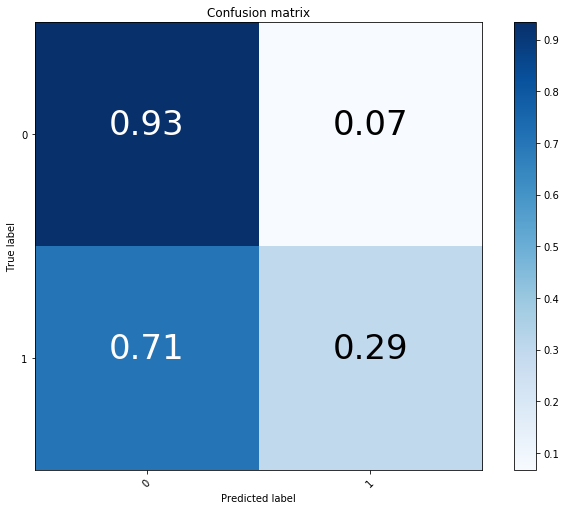

Score on dev set is:0.6882086167800453
Log loss on dev setis:10.768953154001752


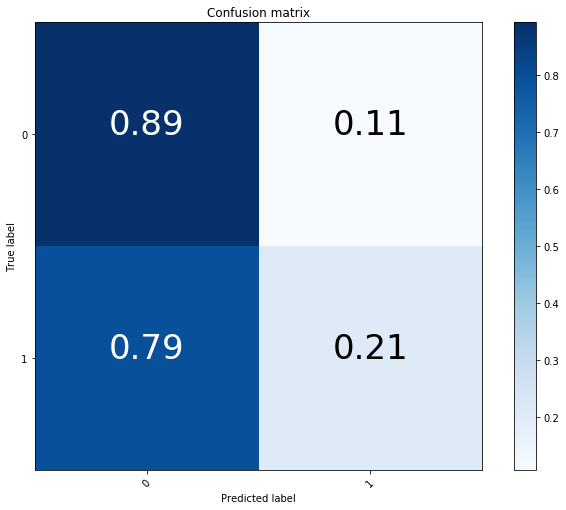

In [196]:
pipeline = Pipeline([
    ("union", features),
    ("classifier", LogisticRegression())
])


try_pipeline(pipeline, train, train[RESULT], dev, dev[RESULT])

Score on train set is:0.7758961992513677
Log loss on train set is:7.7403208366925895


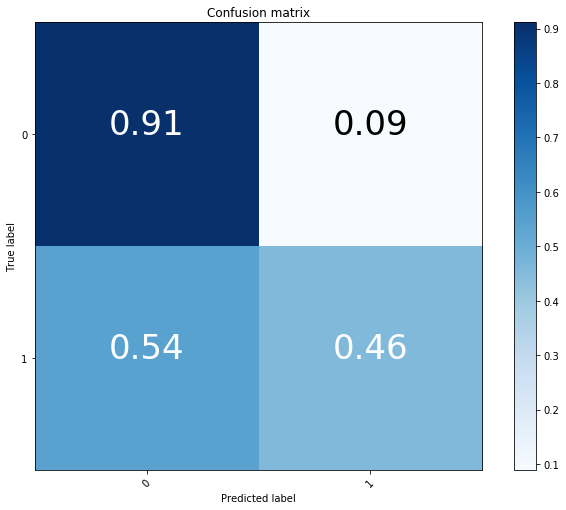

Score on dev set is:0.624023683547493
Log loss on dev setis:12.985875900113781


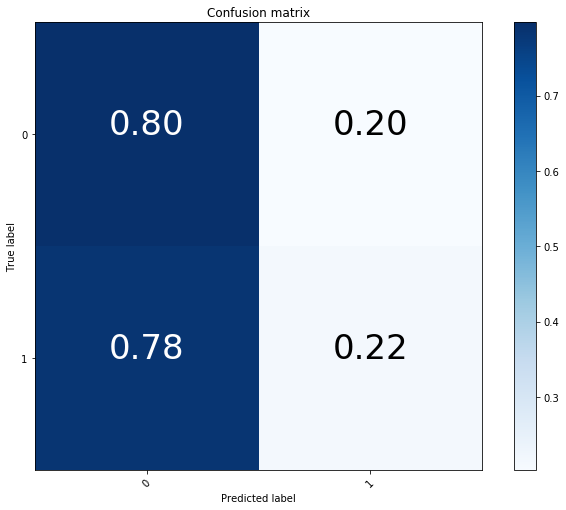

In [197]:
pipeline = Pipeline([
    ("union", features),
    ("classifier", LinearSVC())
])

try_pipeline(pipeline, train, train[RESULT], dev, dev[RESULT])

In [198]:
pipeline = Pipeline([
    ("union", features),
    ("classifier", MultinomialNB())
])

try_pipeline(pipeline, train, train[RESULT], dev, dev[RESULT])

ValueError: Input X must be non-negative

It seems the multinomial nb sucks for some reason (someone should check the pipeline)

I will just check how count vectorizer changes the results when using LinearSVC for model

Score on train set is:0.7915706881658509
Log loss on train set is:7.198946665626658


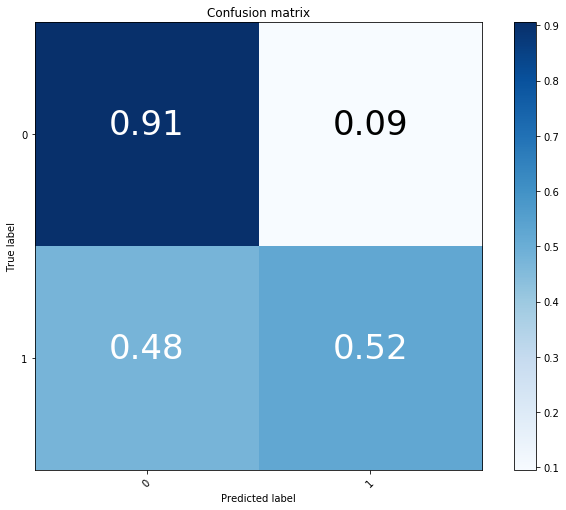

Score on dev set is:0.5577601410934744
Log loss on dev setis:15.274586581377678


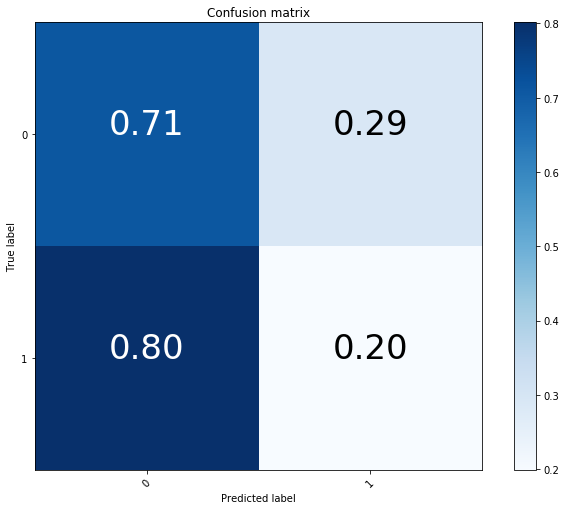

In [36]:
pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("classifier", LinearSVC())
])

try_pipeline(pipeline, train, train[RESULT], dev, dev[RESULT])

Lastly I will check what goes on when using linear naive b

In [39]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [40]:
def get_mdl(train, y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = train.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
# corpus = pd.read_csv("../data/train.csv")
# vec = TfidfVectorizer(ngram_range=(1,2),
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1 )
# vec.fit(corpus)